In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]
import scipy.optimize as opt
import torch
import torch.nn as nn

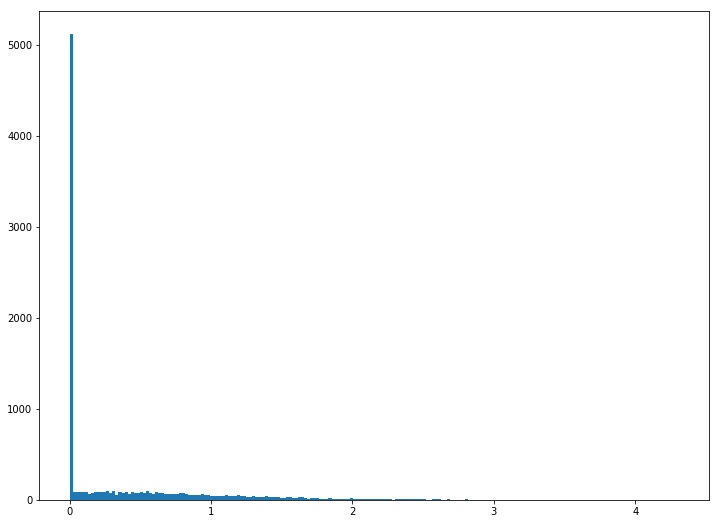

In [4]:
x = torch.tensor(np.random.normal(size=10000), dtype=torch.float32).cuda()
# x = torch.tensor(np.random.laplace(size=10000)*np.random.laplace(size=10000), dtype=torch.float32).cuda()
symmetric = False
if not symmetric:
    # apply relu
    x[x<0] = 0
_=plt.hist(x.cpu(), bins=200)

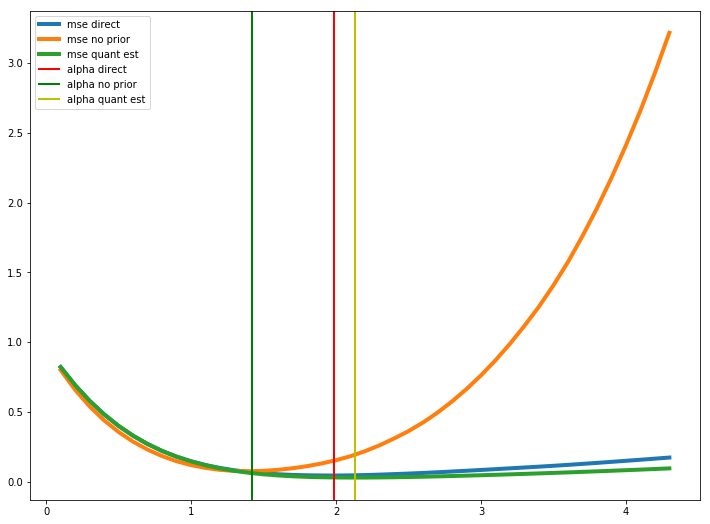

In [6]:
bits = 2
def quant(x, alpha, bits, sym=False):
    if sym:
        qmax = 2 ** (bits - 1) - 1
        qmin = -qmax - 1
    else:
        qmax = 2**bits - 1
        qmin = 0

    delta = (2 if sym else 1) * alpha / (2**bits - 1)
    
    tq = torch.round(x / delta)
    tq = delta * torch.clamp(tq, qmin, qmax)
    return tq    

def mse_direct(alpha, x, bits, sym):
    N = x.numel() if sym else x[x != 0].numel()
    xq = quant(x, alpha, bits, sym=sym)
    err = torch.sum((xq - x) ** 2) / N
    return err.item()

def mse_decomposed(alpha, x, bits, sym):
    N = x.numel() if sym else x[x != 0].numel()
    if alpha > 0:
        xclamp = torch.clamp(x, -alpha, alpha)
        clip_err = torch.sum((xclamp - x) ** 2) / N

        xq = quant(x, alpha, bits, sym=sym)
        quant_err = torch.sum((xq - x) ** 2) / N
        err = clip_err + quant_err
    else:
        err = torch.sum(x**2) / N
    return err.item()

def mse_quant_est(alpha, x, bits, sym):
    N = x.numel() if sym else x[x != 0].numel()
    xclamp = torch.clamp(x, -alpha, alpha)
    clip_err = torch.sum((xclamp - x) ** 2) / N
        
    quant_err = alpha ** 2 / ((3 if sym else 12) * (2 ** (2 * bits)))
    err = clip_err + quant_err
    return err.item()

def mse_no_prior(alpha, x, bits, sym):
    delta = alpha / (2**bits - 1)
    Cx = torch.clamp(x, -delta / 2, alpha + delta / 2)
    Ci = Cx - x

    N = x.numel() if sym else x[x != 0].numel()
    xq = quant(x, alpha, bits, sym=sym)

    qerr_exp = torch.sum((xq - Cx)) / N
    qerrsq_exp = torch.sum((xq - Cx) ** 2) / N
    cerr = torch.sum(Ci ** 2) / N
    mixed_err = 2 * torch.sum(Ci) * alpha * qerr_exp / N
    mse = alpha ** 2 * qerrsq_exp + cerr + mixed_err
    return mse.item()

opt_alpha1 = opt.minimize_scalar(lambda alpha: mse_direct(alpha, x, bits, symmetric), bounds=(x.min().item(), x.max().item())).x
opt_alpha2 = opt.minimize_scalar(lambda alpha: mse_no_prior(alpha, x, bits, symmetric), bounds=(x.min().item(), x.max().item())).x
opt_alpha3 = opt.minimize_scalar(lambda alpha: mse_quant_est(alpha, x, bits, symmetric), bounds=(x.min().item(), x.max().item())).x

mses_direct = []
mses_decomposed = []
mses_quant_est = []
alphas = np.arange(0.1, x.max().item(), 0.1)
for alpha in alphas:
    mses_direct.append(mse_direct(alpha, x, bits, symmetric))
    mses_decomposed.append(mse_no_prior(alpha, x, bits, symmetric))
    mses_quant_est.append(mse_quant_est(alpha, x, bits, symmetric))
    
_=plt.plot(alphas, mses_direct, linewidth=4)
_=plt.plot(alphas, mses_decomposed, linewidth=4)
_=plt.plot(alphas, mses_quant_est, linewidth=4)
_=plt.axvline(opt_alpha1, linewidth=2, c='r')
_=plt.axvline(opt_alpha2, linewidth=2, c='g')
_=plt.axvline(opt_alpha3, linewidth=2, c='y')
plt.legend(['mse direct', 'mse no prior', 'mse quant est', 'alpha direct', 'alpha no prior', 'alpha quant est'])
# plt.legend(['mse direct', 'mse quant est', 'alpha direct', 'alpha quant est'])
